In [1]:
import os
import datetime

import librosa
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_probability as tfp

import pandas as pd
import numpy as np

import sklearn
from sklearn.utils import class_weight

from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt

2024-05-25 09:43:50.004515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 09:43:50.004624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 09:43:50.284881: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# !conda install -y gdown

In [3]:
# !gdown --id 1rcluM4ednAqs_tcYilHvJHHSs5Bjt8Ib

In [4]:
# https://drive.google.com/file/d/1rcluM4ednAqs_tcYilHvJHHSs5Bjt8Ib/view?usp=sharing

# CONFIG

In [12]:
class CFG:
    device = 'CPU'
    seed = 42
    
    # Input image size and batch size
    img_size = [260, 260]
    H = 260
    W = 260
    batch_size = 32
    upsample_thr = 30 # min sample of each class (upsample)
    cv_filter = True # always keeps low sample data in train

    # Audio duration, sample rate, and length
    duration = 10 # second
    sample_rate = 44100
    audio_len = duration*sample_rate

    # STFT parameters
    nfft = 520
    window = 520
    hop_length = 260
    fmin = 0
    fmax = 32000
    normalize = True
    nmels = 260
    
    # Inference batch size, test time augmentation, and drop remainder
    infer_bs = 2
    tta = 1
    drop_remainder = True
    
    # Number of epochs, model name, and number of folds
    epochs = 25
    model_name = 'EfficientNetB1'
    fsr = False # reduce stride of stem block
    num_fold = 5
    
    # Selected folds for training and evaluation
    selected_folds = [0]

    # Pretraining, neck features, and final activation function
    pretrain = 'imagenet'
    neck_features = 0
    final_act = 'softmax'
    
    # Learning rate, optimizer, and scheduler
    lr = 1e-3
    scheduler = 'cos'
    optimizer = 'Adam' # AdamW, Adam
    
    # Loss function and label smoothing
    loss = 'CCE' # BCE, CCE
    label_smoothing = 0.05 # label smoothing
    
    # Data augmentation parameters
    augment=True
    spec_augment_prob = 0.40
    
    # Time Freq masking
    freq_mask_prob=0.80
    num_freq_masks=1
    freq_mask_param=5
    time_mask_prob=0.50
    num_time_masks=2
    time_mask_param=35

    # Audio Augmentation Settings
    audio_augment_prob = 0.5
    
    mixup_prob = 0.65
    mixup_alpha = 0.5
    
    cutmix_prob = 0.65
    cutmix_alpha = 2.5
    
    timeshift_prob = 0.0
    
    gn_prob = 0.35

    class_names = sorted(set(os.listdir('/kaggle/input/spectrogram-dataset-v2/audios')))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}
    
    # Training Settings
    target_col = ['target']
    tab_cols = ['filename']
    monitor = 'auc'
    debug = True
    verbose = 0

In [13]:
tf.keras.utils.set_random_seed(CFG.seed)
tf.config.optimizer.set_jit(True)

# LOAD DATASET

In [14]:
def upsample_data(df, thr=20):
    # get the class distribution
    class_dist = df['target'].value_counts()

    # identify the classes that have less than the threshold number of samples
    down_classes = class_dist[class_dist < thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    up_dfs = []

    # loop through the undersampled classes and upsample them
    for c in down_classes:
        # get the dataframe for the current class
        class_df = df.query("target==@c")
        # find number of samples to add
        num_up = thr - class_df.shape[0]
        # upsample the dataframe
        class_df = class_df.sample(n=num_up, replace=True, random_state=CFG.seed)
        # append the upsampled dataframe to the list
        up_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    up_df = pd.concat([df] + up_dfs, axis=0, ignore_index=True)
    
    return up_df

In [15]:
def downsample_data(df, thr=500):
    # get the class distribution
    class_dist = df['target'].value_counts()
    
    # identify the classes that have less than the threshold number of samples
    up_classes = class_dist[class_dist > thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    down_dfs = []

    # loop through the undersampled classes and upsample them
    for c in up_classes:
        # get the dataframe for the current class
        class_df = df.query("target==@c")
        # Remove that class data
        df = df.query("target!=@c")
        # upsample the dataframe
        class_df = class_df.sample(n=thr, replace=False, random_state=CFG.seed)
        # append the upsampled dataframe to the list
        down_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    down_df = pd.concat([df] + down_dfs, axis=0, ignore_index=True)
    
    return down_df

In [16]:
def load_spectrogram_dataset():
    base_dir = f"/kaggle/input/spectrogram-dataset-v2/audios"
    data = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(('.jpeg')) and not file.endswith(('noisy.jpeg')):
                label = os.path.basename(root)
                file_path = os.path.join(root, file)
                data.append((file_path, label, CFG.name2label[label]))
    return pd.DataFrame(data, columns=['image_path', 'label', 'target'])

In [17]:
df = load_spectrogram_dataset()
df = upsample_data(df, thr=70)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,image_path,label,target
0,/kaggle/input/spectrogram-dataset-v2/audios/bl...,blnwea1,33
1,/kaggle/input/spectrogram-dataset-v2/audios/ca...,carcha1,55
2,/kaggle/input/spectrogram-dataset-v2/audios/ch...,chewea1,60
3,/kaggle/input/spectrogram-dataset-v2/audios/re...,reedov1,147
4,/kaggle/input/spectrogram-dataset-v2/audios/co...,combuz1,65


In [18]:
print(df.shape)
df['target'].nunique()

(17779, 3)


203

In [19]:
df = downsample_data(df, 500)

In [20]:
df['target'].value_counts()

target
66     400
62     325
189    300
76     300
19     300
      ... 
143     70
67      70
179     70
92      70
0       70
Name: count, Length: 203, dtype: int64

In [21]:
from sklearn.model_selection import train_test_split
train_val_df, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])
df_train, df_val = train_test_split(train_val_df, test_size=0.25, random_state=42, stratify=train_val_df['target'])

In [22]:
df_train['target'].nunique(), df_val['target'].nunique(),df_test['target'].nunique() 

(203, 203, 203)

In [23]:
df_val.shape

(3556, 3)

# UTILITY

In [24]:
def get_timestamp():
    now = datetime.datetime.now()
    return now.strftime("%Y-%m-%d__%H-%M-%S")

In [25]:
# Generates random integer
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)


# Generats random float
def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

In [26]:
# Convert img (H,W,3) to image (H,W)
@tf.function
def Img2Spec(img):
    # Extract the first channel of the image
    return img[..., 0]

# Convert spectrogram (H,W) to image (H,W,3)
@tf.function
def Spec2Img(spec, num_channels=3):
    # If the original image has 1 channel, convert it to a 3 channel image by repeating the same image across channel axis
    if num_channels > 1:
        img = tf.tile(spec[..., tf.newaxis], [1, 1, num_channels])
    else:
        img = spec[..., tf.newaxis]
    return img

In [27]:
spec_img = Image.open(df_train.iloc[1].image_path)

In [28]:
spec_tensor = tf.keras.utils.img_to_array(spec_img)
print(spec_tensor.shape)
spec = Img2Spec(spec_tensor)
spec.shape

(1697, 260, 3)


TensorShape([1697, 260])

# AUGMENTATION

In [29]:
# Randomly mask data in time and freq axis
@tf.function
def TimeFreqMask(spec):
    if random_float() < CFG.freq_mask_prob:
        # Apply frequency masking to the spectrogram
        spec = tfio.audio.freq_mask(spec, param=CFG.freq_mask_param)
    if random_float() < CFG.time_mask_prob:
        # Apply time masking to the spectrogram
        spec = tfio.audio.time_mask(spec, param=CFG.time_mask_param)
    return spec

In [30]:
def SpecAug(spec):
    # Convert the spectrogram to a 2D matrix and transpose it to get the shape [batch_size, time, mel]
    # spec = tf.map_fn(lambda s : tf.transpose(Img2Spec(s), perm=[1, 0]), spec)
    spec = tf.map_fn(Img2Spec, spec)

    # Apply time and frequency masking to the spectrogram
    spec = tf.map_fn(TimeFreqMask, spec)
    # Transpose the spectrogram back to the original shape [mel, time] and convert it to an image
#     spec = tf.transpose(spec, perm=[0, 2, 1])
    spec = tf.map_fn(Spec2Img, spec)
    return spec

In [31]:
# Applies augentation to spectrogram
def spec_augmenter(with_labels=True, dim=CFG.img_size, CFG=CFG):
    def augment(spec, dim=dim): 
        if random_float() <= CFG.spec_augment_prob:
            spec = SpecAug(spec)
        spec = tf.map_fn(lambda s : tf.reshape(s, [*dim, 3]), spec)
        return spec
    
    def augment_with_labels(spec, label):    
        return augment(spec), label
    
    return augment_with_labels if with_labels else augment

In [32]:
# Compute MixUp Augmentation for Spectrogram
def MixUp(alpha=0.2, prob=0.5):
    """Apply Spectrogram-MixUp augmentaiton. Apply Mixup to one batch and its shifted version"""
    @tf.function
    def apply(specs, labels, alpha=alpha, prob=prob):
        tf.print(specs.shape)
        if random_float() > prob:
            return specs, labels

        spec_shape = tf.shape(specs)
        label_shape = tf.shape(labels)

        # Select lambda from beta distribution
        beta = tfp.distributions.Beta(alpha, alpha)
        lam = beta.sample(1)[0]
        # It's faster to roll the batch by one instead of shuffling it to create image pairs
        specs = lam * specs + (1 - lam) * tf.roll(specs, shift=1, axis=0) # mixup = [1, 2, 3]*lam + [3, 1, 2]*(1 - lam)
        labels = lam * labels + (1 - lam) * tf.roll(labels, shift=1, axis=0)

        specs = tf.reshape(specs, spec_shape)
        labels = tf.reshape(labels, label_shape)
        return specs, labels
    return apply

In [33]:
def CutMix(alpha, prob=0.5):
    """Apply Spectrogram-CutMix augmentaiton which only cuts patch across time axis unlike 
       typical Computer-Vision CutMix. Applies CutMix to one batch and its shifted version.
    """
    @tf.function
    def apply(specs, labels, alpha=alpha, prob=prob):
        if random_float() > prob:
            return specs, labels
        spec_shape = tf.shape(specs)
        label_shape = tf.shape(labels)
        W = tf.cast(spec_shape[1], tf.int32)  # [batch, time, freq, channel]

        # Lambda from beta distribution
        beta = tfp.distributions.Beta(alpha, alpha)
        lam = beta.sample(1)[0]
        
        # It's faster to roll the batch by one instead of shuffling it to create image pairs
        specs_rolled = tf.roll(specs, shift=1, axis=0) # specs->[1, 2, 3], specs_rolled->[3, 1, 2]
        labels_rolled = tf.roll(labels, shift=1, axis=0)

        # Select random patch size
        r_x = random_int([], minval=0, maxval=W)
        r = 0.5 * tf.math.sqrt(1.0 - lam)
        r_w_half = tf.cast(r * tf.cast(W, tf.float32), tf.int32)

        # Select random location in time axis
        x1 = tf.cast(tf.clip_by_value(r_x - r_w_half, 0, W), tf.int32)
        x2 = tf.cast(tf.clip_by_value(r_x + r_w_half, 0, W), tf.int32)
        
        print(x1, x2)
        # outer-pad patch -> [0, 0, x, x, 0, 0]
        patch1 = specs[:, x1:x2, :, :]  # [batch, time, freq, channel]
        patch1 = tf.pad(
            patch1, [[0, 0], [x1, W - x2], [0, 0], [0, 0]])  # outer-pad

        # inner-pad-patch -> [y, y, 0, 0, y, y]
        patch2 = specs_rolled[:, x1:x2, :, :]  # [batch, mel, time, channel]
        patch2 = tf.pad(
            patch2, [[0, 0], [x1, W - x2], [0, 0], [0, 0]])  # outer-pad
        patch2 = specs_rolled - patch2  # inner-pad-patch = img - outer-pad-patch
        
        # patch1 -> [0, 0, x, x, 0, 0], patch2 -> [y, y, 0, 0, y, y]
        # cutmix = (patch1 + patch2) -> [y, y, x, x, y, y]
        specs = patch1 + patch2  # cutmix img

        # Compute lambda = [1 - (patch_area/image_area)]
        lam = tf.cast((1.0 - (x2 - x1) / (W)),tf.float32)  # no H term as (y1 - y2) = H
        labels = lam * labels + (1.0 - lam) * labels_rolled  # cutmix label

        specs = tf.reshape(specs, spec_shape)
        labels = tf.reshape(labels, label_shape)

        return specs, labels
    return apply

# DATA LOADER

In [34]:
if (not os.path.exists(("/kaggle/working/cache"))):
    os.mkdir("/kaggle/working/cache")

In [141]:
@tf.function
def parse_image(image_path):
    spec_img = tf.io.decode_jpeg(
        tf.io.read_file(image_path), channels=3, name="decoding_jpeg"
    )
    spec_img = spec_img[:,:,:3]
    spec_img = tf.image.resize_with_crop_or_pad(
        spec_img, CFG.H, CFG.W
    )
    spec_img = tf.cast(spec_img, tf.float32, name="casting_to_f32")
    spec_img = spec_img / 255.0 # Normalize
#     return Img2Spec(spec_img)
    return spec_img

In [142]:
x = tf.convert_to_tensor(["/kaggle/input/spectrogram-dataset-v2/audios/abethr1/XC128013.jpeg",
                         "/kaggle/input/spectrogram-dataset-v2/audios/abethr1/XC128013_noisy.jpeg"
                         ])

In [143]:
spec_img = tf.map_fn(parse_image, x, fn_output_signature=tf.float32)

In [144]:
spec_img.shape

TensorShape([2, 260, 260, 3])

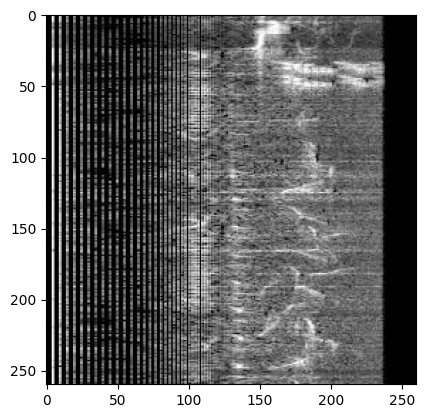

In [145]:
plt.figure()
plt.imshow(spec_img[0])

In [146]:
@tf.function
def parse_image_wrapper(paths, labels):
    specs = tf.map_fn(parse_image, paths, name="parse_image_mapper", fn_output_signature=tf.float32)
    return specs, labels

In [147]:
spec_img.shape

TensorShape([2, 260, 260, 3])

In [148]:
spec_img_aug = SpecAug(spec_img)
spec_img_aug.shape

TensorShape([2, 260, 260, 3])

(260, 260, 3)


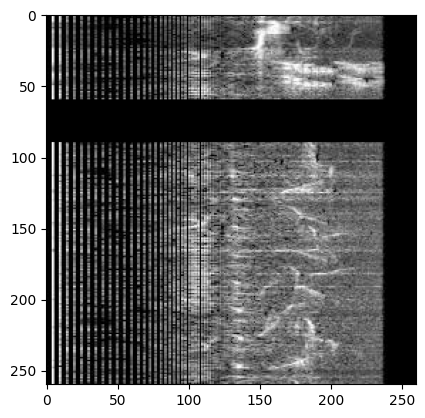

In [149]:
plt.figure()
print(spec_img_aug[0].shape)
plt.imshow(spec_img_aug[0])

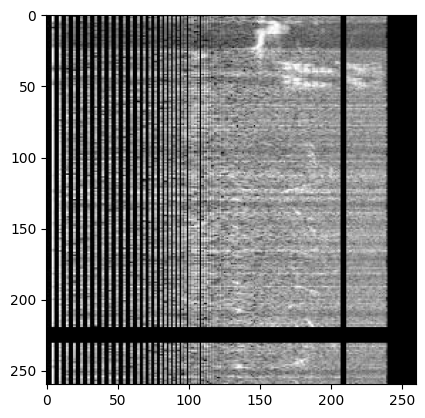

In [150]:
plt.figure()
plt.imshow(spec_img_aug[1])

In [205]:
# @tf.function
def build_dataset(paths, labels, n_classes = 203, dataset="train"):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.cache("/kaggle/working/cache")
    ds = ds.repeat(2)
    
    if dataset == "train":
        ds = ds.shuffle(buffer_size=1000, seed=CFG.seed)
    
    ds = ds.batch(CFG.batch_size, drop_remainder=False)

    ds = ds.map(parse_image_wrapper ,num_parallel_calls=tf.data.AUTOTUNE)
    
    if dataset=="train":
        ds = ds.map(spec_augmenter(), num_parallel_calls=tf.data.AUTOTUNE)
#         ds = ds.map(MixUp(alpha=CFG.mixup_alpha,prob=CFG.mixup_prob),num_parallel_calls=tf.data.AUTOTUNE)
#         ds = ds.map(CutMix(alpha=CFG.cutmix_alpha,prob=CFG.cutmix_prob),num_parallel_calls=tf.data.AUTOTUNE)
#     ds = ds.map(lambda img, l : (img, tf.one_hot(tf.cast(l, tf.int32), n_classes)), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(lambda img, l: (Img2Spec(img),l), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [206]:
paths_train = list(df_train['image_path'])
targets_train = list(df_train['target'])

In [207]:
ds_train = build_dataset(tf.convert_to_tensor(paths_train), tf.convert_to_tensor(targets_train, dtype=tf.float32))

In [208]:
# ds = ds_train.take(64)
# for img, label in ds:
#     print(img)
#     print(label)
#     break

In [209]:
paths_test = list(df_test['image_path'])
targets_test = list(df_test['target'])

In [210]:
ds_test = build_dataset(tf.convert_to_tensor(paths_test), tf.convert_to_tensor(targets_test, dtype=tf.float32), dataset="test")

In [211]:
paths_val = list(df_val['image_path'])
targets_val = list(df_val['target'])

In [212]:
ds_val = build_dataset(tf.convert_to_tensor(paths_val), tf.convert_to_tensor(targets_val, dtype=tf.float32), dataset="val")

# MODEL

In [213]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    # Check TPU category
    tpu = 'local' if CFG.device=='TPU-VM' else None
    try:
        # Connect to TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu) 
        # Set TPU strategy
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on {CFG.device}', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device, tpu

In [214]:
def build_model(N_CLASSES):
#     he = tf.keras.initializers.HeNormal()
    inputs = tf.keras.layers.Input(shape=(CFG.H, CFG.W, 3))
    model = tf.keras.applications.EfficientNetB2(include_top=False, input_tensor=inputs, classes=N_CLASSES, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = tf.keras.layers.Dense(1024, activation="relu", name="FC_1")(x)
    outputs = tf.keras.layers.Dense(N_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])
    return model


In [215]:
def LSTM(N_CLASSES):
    i = tf.keras.layers.Input(shape=(CFG.H, CFG.W))
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Reshape((-1,)), name='reshape')(i)
    s = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation='tanh'), name='td_dense_tanh')(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True), name='bidirectional_lstm')(s)
    x = tf.keras.layers.concatenate([s, x], axis=2, name='skip_connection')
    x = tf.keras.layers.Dense(64, activation='relu', name='dense_1_relu')(x)
    x = tf.keras.layers.MaxPooling1D(name='max_pool_1d')(x)
    x = tf.keras.layers.Dense(32, activation='relu', name='dense_2_relu')(x)
    x = tf.keras.layers.Flatten(name='flatten')(x)
    x = tf.keras.layers.Dropout(rate=0.2, name='dropout')(x)
    x = tf.keras.layers.Dense(32, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.001), name='dense_3_relu')(x)
    o = tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='softmax')(x)
    model = tf.keras.Model(inputs=i, outputs=o, name='long_short_term_memory')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])
    return model

In [216]:
strategy, CFG.device, tpu = get_device()
CFG.replicas = strategy.num_replicas_in_sync
CFG.replicas, CFG.device

> Running on GPU | Num of GPUs:  2


(2, 'GPU')

In [217]:
n_classes = df_train['target'].nunique()
n_classes

203

In [218]:
# with strategy.scope():
model = LSTM(n_classes)

In [219]:
model.summary()

Model: "long_short_term_memory"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 260, 260)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape             │ (None, 260, 260)  │          0 │ input_layer_13[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_dense_tanh       │ (None, 260, 64)   │     16,704 │ reshape[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm  │ (None, 260, 64)   │     24,832 │ td_dense_tanh[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection     │ (None, 260, 128)  │          0 │ td_dense_tanh[0]… │
│ (Concatenate)       │                   │            │ bidirectional_ls… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1_relu        │ (None, 260, 64)   │      8,256 │ skip_connection[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool_1d         │ (None, 130, 64)   │          0 │ dense_1_relu[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2_relu        │ (None, 130, 32)   │      2,080 │ max_pool_1d[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4160)      │          0 │ dense_2_relu[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4160)      │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_relu        │ (None, 32)        │    133,152 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Dense)     │ (None, 203)       │      6,699 │ dense_3_relu[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 191,723 (748.92 KB)

 Trainable params: 191,723 (748.92 KB)

 Non-trainable params: 0 (0.00 B)

In [220]:
# model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=CFG.lr),
#               loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=CFG.label_smoothing), 
#               metrics=['accuracy'])

In [221]:
checkpoint_path = f"/kaggle/working/{get_timestamp()}/cp.weights.h5"

callbacks = [
#             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.7),
             tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
             tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_weights_only=True, save_best_only=True)]

In [222]:
# y = list(np.squeeze(targets_train))
# classes = [i for i in range(0, n_classes)]

# class_weights = class_weight.compute_class_weight("balanced", classes=classes, y=y)
# class_weights_dict = {i : class_weights[i] for i,label in enumerate(classes)}

In [224]:
history = model.fit(ds_train, validation_data=ds_val, epochs=50, verbose=1, callbacks=callbacks)

Epoch 1/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 59s 88ms/step - accuracy: 0.0201 - loss: 5.2855 - val_accuracy: 0.0262 - val_loss: 5.2030
Epoch 2/50
666/667 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.0266 - loss: 5.1911

W0000 00:00:1716635837.715388     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


667/667 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - accuracy: 0.0265 - loss: 5.1911 - val_accuracy: 0.0261 - val_loss: 5.1545
Epoch 3/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 72s 73ms/step - accuracy: 0.0266 - loss: 5.1493 - val_accuracy: 0.0270 - val_loss: 5.1206
Epoch 4/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 50s 74ms/step - accuracy: 0.0276 - loss: 5.1144 - val_accuracy: 0.0324 - val_loss: 5.0766
Epoch 5/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 50s 74ms/step - accuracy: 0.0329 - loss: 5.0713 - val_accuracy: 0.0419 - val_loss: 5.0148
Epoch 6/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 48s 71ms/step - accuracy: 0.0414 - loss: 5.0094 - val_accuracy: 0.0530 - val_loss: 4.8840
Epoch 7/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 82s 71ms/step - accuracy: 0.0573 - loss: 4.8682 - val_accuracy: 0.0862 - val_loss: 4.7056
Epoch 8/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 48s 71ms/step - accuracy: 0.0876 - loss: 4.7014 - val_accuracy: 0.1194 - val_loss: 4.5271
Epoch 9/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 48s 71ms/step - accuracy: 0.1201 - loss: 4.5398 - val_accurac

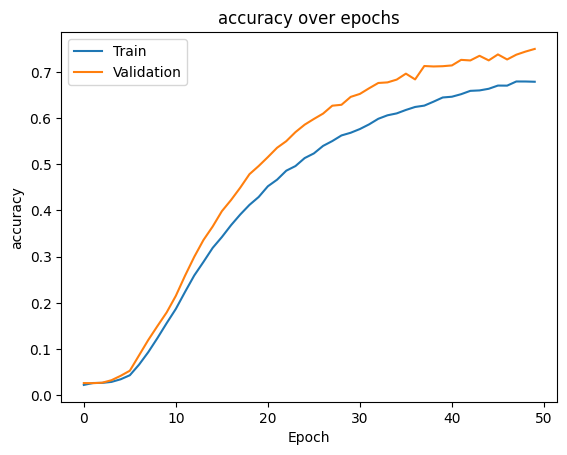

In [225]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy over epochs')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [199]:
# model.load_weights('/kaggle/working/2024-05-23__14-06-23/cp.weights.h5')

In [228]:
result = model.evaluate(ds_test)

223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.7466 - loss: 1.5288


In [229]:
model.save(f"EffNetb0__{get_timestamp()}.keras")

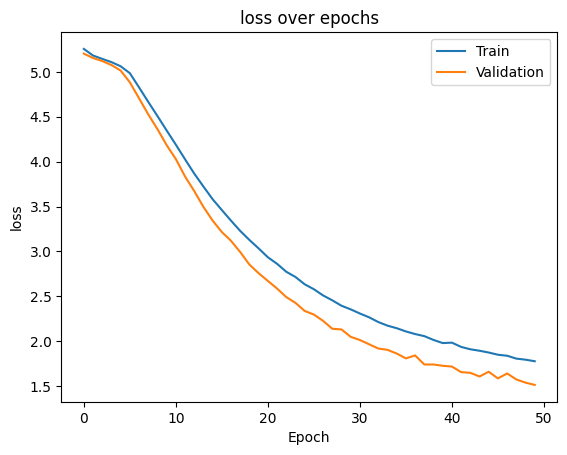

In [227]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss over epochs')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()